In [1]:
#Importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from ta import add_all_ta_features
from ta.utils import dropna

#Extracts data from the yahoo finance and gives us the latest data
import yfinance as yf

#Importing Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Importing feature selection libraries
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA


#Importing libraries for LSTMs and defining accuracy
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score, r2_score

import warnings
warnings.filterwarnings('ignore')

# Importing data and processing it using TA lib

In [27]:
#Returns X and y data in dataframe form processed and with TA lib features
#time is 10 years
def process_data(stock_name):
    start = datetime.datetime(2020,4,6)
    end = datetime.datetime(2022,4,6)
    stock = yf.download(stock_name,start,end)
    
    df = add_all_ta_features(
        stock, open="Open", high="High", low="Low", close="Close", volume="Volume")
    
    #Drops columns that have major null values
    
    df.drop(columns = ["trend_psar_up","trend_psar_down"], inplace = True)
    df.dropna(inplace = True)
    
    #Splits data into features and target values
    
    X = df.drop("Close",axis = 1)
    y = df["Close"]

    
    return X, y

In [28]:
# define the lasso regression class
class LassoRegression() :

  # define the constructor and pass
  # learning rate, iterations i.e epochs and l1 penality for Lasso
  def __init__( self, lr, epochs, l1_penality ) :

      self.lr = lr
      self.epochs = epochs
      self.l1_penality = l1_penality
      
  # fit the model on training data
  def fit( self, X, Y ) :
      
      # no_of_training_examples, no_of_features
      self.m, self.n = X.shape
      
      # weight initialization
      self.W = np.zeros( self.n )
      
      self.b = 0
      self.X = X
      self.Y = Y
      
      # gradient descent learning
      for i in range( self.epochs ) :
          self.update_weights()
      return self

  # function to update weights in gradient descent
  def update_weights( self ) :

      Y_pred = self.predict( self.X )
      
      # calculate gradients
      dW = np.zeros( self.n )

      # add or subtract penalty depending upon positivity or negativity of weights
      for j in range( self.n ):
          if self.W[j] > 0 :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      + self.l1_penality ) / self.m
          else :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      - self.l1_penality ) / self.m

      db = - 2 * np.sum( self.Y - Y_pred ) / self.m
      
      # update weights
      self.W = self.W - self.lr * dW
      self.b = self.b - self.lr * db
      
      return self

  # predict the output
  def predict( self, X ) :
      return X.dot( self.W ) + self.b

In [29]:
def perform_lasso(X_train, X_test):
  # Model training
  model = LassoRegression( epochs = 1000, lr = 0.01, l1_penality = 500 )
  model.fit( X_train, y_train )

  # Prediction on test set
  y_pred = model.predict( X_test )

  return model.W, X_train

In [30]:
from seaborn.utils import axes_ticklabels_overlap
def bar_importance(coeff, X_train, feature_names, thresh):

  # steps for feature importance
  feature_importance = np.std(X_train, 0)*np.array(coeff)
  
  above_threshold ={}
  # print feature name and their importance
  for name,importance in zip(feature_names,feature_importance):
      if abs(importance) >= thresh:
        above_threshold[name] = importance

  #create a dataframe containing feature name and their importance
  dff = pd.DataFrame([])
  dff['features'] = above_threshold.keys()
  dff['importance'] = above_threshold.values()

  d = dff.groupby(['features']).sum().sort_values('importance',ascending=False)
  
  # plot graph for feature importance
  #d['importance'].plot.bar()
  return above_threshold

# K- Feature Selector

In [31]:
#Defines k_best_selector which selects the best k features contributing to the target values
def K_best_selector(X, y):
    select = SelectKBest(f_regression, k = 25)
    select.fit_transform(X, y)
    cols = select.get_support(indices=True)
    #Keeping the columns that are most contributing from all the feature values
    X = X.iloc[:,cols]
    return X,y

# PCA features

In [32]:
def pca_selector(X, y):    
    
    #Splitting data for training and testing

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, shuffle = None)
    
    def get_variance(comp_count, train, test):
      pca = PCA(n_components=comp_count)
      train = pca.fit_transform(train)
      test = pca.transform(test)

      return pca.explained_variance_ratio_, train, test, pca

    components = 1
    explained_variance = 0
    while np.sum(explained_variance) < .95:

        explained_variance, X_train_fit, X_test_fit, pca = get_variance(components, X_train, X_test)

        components += 1

    # Reformats the principal components into a usable dictionary
    vals = np.array(pca.components_).T
    #print(vals)
    pc_lst = [f'PC{num+1}' for num in range(len(vals.T))]
    data = pd.DataFrame(vals, columns=pc_lst, index=X.columns)
    # Creates an empty dictionary to store feature importance
    feature_importance = {feature:0 for feature in X.columns}

    # Populates dictionary with their principal component correspondants
    for key in feature_importance.keys():
      feature_importance[key] = sum(data.loc[key])

    # Creates an ordered list of the importance values from the dictionary
    features_ordered = list(feature_importance.items())
    features_ordered = sorted(features_ordered, key = lambda x: x[1])[::-1]

    # Creates a list of bar heights and labels for each val above a threshold
    thresh  = 0.000001
    height = [val for name, val in features_ordered if val >= thresh]
    
    #Keeping the columns that are most contributing from all the feature values

    x = [name for name, val in features_ordered][:len(height)]
    X = X.loc[:,x]
    print(X)
    print(y)
    return X, y

# Making a model with all the layers and activation functions

In [33]:
#Defining the LSTM and adding layers to it
def make_model():
    model = Sequential()
    model.add(LSTM(units = 180, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dense(units = 1))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = "mae")
    
    return model

# Plotting function

In [52]:
#The plot function here plots the predicted values against the actual values and displays the figure
def plot_values(pred_vals, actual_vals):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(pred_vals)
    plt.plot(actual_vals)
    plt.xlabel("Time in days")
    plt.ylabel("Closing Value in $")
    plt.title("Pred vs actual values")
    plt.legend("predicted values","actual values",prop={'size': 6})
    plt.show()
    plt.clf()

# Predictor function

Normalises data, feeds it into the model and gets prediction. Next, it plots the data using matplotlib

In [35]:
def create_model(X, y):
    
    #Defines the scaler for scaling down the data to values between 0 and 1. 
    scaler = MinMaxScaler()
    
    y = np.array(y)
    
    #Transforms the target data and feature data
        
    X_transformed = scaler.fit_transform(X)
    y_transformed = scaler.fit_transform(y.reshape(-1,1))
    
    #Splitting the data into training and testing
    
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.2, shuffle = None)
    
    train_len = len(X_train)
    test_len = len(X_test)
    
    X_train = np.array(X_train)
    X_train = X_train.reshape(train_len,-1,1)
    
    #Calls the make_model funtion that creates the sequential LSTM model
    predictor = make_model()
    
    #Trains the data on the new model with the training data for 10 epochs.
    predictor.fit(X_train, y_train, epochs = 10)
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(test_len,-1,1)
    y_test = np.reshape(y_test,(-1,1))
    
    #Here we calculate the predicted values using the trained data.
    
    y_pred = predictor.predict(X_test)
    
    #Inversing the transformed data to get the actual values matching to the real dataset
    
    y_pred_inv_transformed = scaler.inverse_transform(y_pred)
    y_actual_inv_transformed = scaler.inverse_transform(y_test)
    
    #Plotting the graph against the predicted values and real values
    plot_values(y_pred_inv_transformed, y_actual_inv_transformed)   
    
    #Calculating the r2 score to determine how accurate the model is.
    print("The r2 score of this prediction is : ", r2_score(y_actual_inv_transformed, y_pred_inv_transformed))

In [36]:
#Calls all the functions to predict the values defined after selecting the features using the kbest methid.
def final_kbest_func(name):
    X, y = process_data(name)
    new_X, new_y = K_best_selector(X, y)
    create_model(new_X, new_y)

In [37]:
#Calls all the functions to predict the values defined after selecting the features using the pca methid.
def final_pca_func(name):
    X, y = process_data(name)
    new_X, new_y = pca_selector(X, y)
    create_model(new_X, new_y)    

In [49]:
stocks = ['OKE','ITW','GOOG','AAPL', 'SPRO', 'CHGG']


[*********************100%***********************]  1 of 1 completed
            volume_obv    Volume     volume_vpt  trend_aroon_down
Date                                                             
2020-07-23    16095400   6662200 -188457.416702              60.0
2020-07-24    12828200   3267200 -149028.560481              56.0
2020-07-27     5970200   6858000 -194227.759438              52.0
2020-07-28    11658200   5688000 -159031.828433              48.0
2020-07-29    22422900  10764700  644947.962967              44.0
...                ...       ...            ...               ...
2022-03-30    21405700   1749900   17571.222586               4.0
2022-03-31    18571500   2834200  -31140.147651              12.0
2022-04-01    20620400   2048900  -19477.773099               8.0
2022-04-04    18870500   1749900   16837.664292               4.0
2022-04-05    16696300   2174200  -47000.304986              40.0

[430 rows x 4 columns]
Date
2020-07-23    28.959999
2020-07-24    28.719

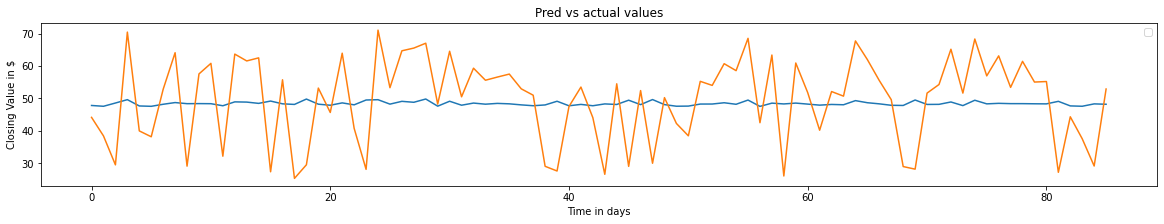

The r2 score of this prediction is :  0.008250078689592821
[*********************100%***********************]  1 of 1 completed
              volume_adi  volume_obv      volume_fi    volume_vpt  \
Date                                                                
2020-07-17 -1.846567e+05    16119000  767121.662045   1811.311291   
2020-07-20 -7.214584e+05    15273000  205526.475008 -12291.084880   
2020-07-21  1.134335e+04    16211100  658617.796536   1559.448192   
2020-07-22  3.537444e+05    17102700  651141.178421  22268.985765   
2020-07-23  3.486947e+05    17809500  678277.256587   7938.019845   
...                  ...         ...            ...           ...   
2022-03-30 -1.169457e+07    29371900  260186.806916   1276.814261   
2022-03-31 -1.318050e+07    27864000 -910063.983442 -52439.552505   
2022-04-01 -1.256748e+07    28879100 -671294.128664 -33313.703293   
2022-04-04 -1.198557e+07    28084100 -711680.335120   -903.858056   
2022-04-05 -1.249600e+07    27371700 -866476

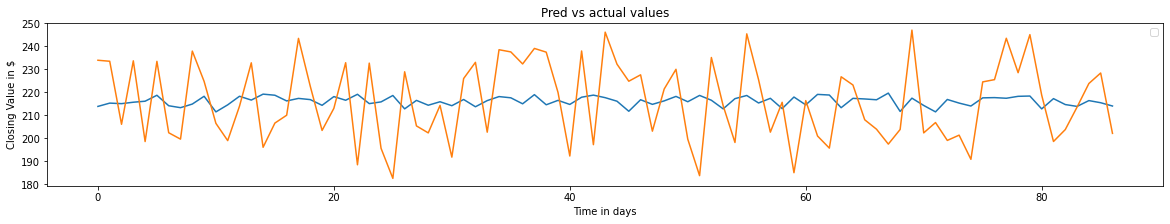

The r2 score of this prediction is :  0.000758945257382182
[*********************100%***********************]  1 of 1 completed
               volume_fi   Volume      volume_em    volume_vpt  volume_sma_em  \
Date                                                                            
2020-07-17  1.688434e+06  1456700   14479.134506   2025.271691   17866.541330   
2020-07-20  1.260860e+07  1557300  111407.113482  49200.971884   29930.104230   
2020-07-21  9.539064e+06  1216200   90609.987160  45881.644875   32762.613860   
2020-07-22  9.517082e+06   932000  -32272.782446    351.902632   27105.742061   
2020-07-23 -4.121565e+06  1627600  -72967.633014 -48777.881606   16521.802228   
...                  ...      ...            ...           ...            ...   
2022-03-30  1.966711e+07  1052300  -24895.113842   8683.896256   62462.984409   
2022-03-31  4.228914e+06  1475800 -138790.969388 -35434.201878   54406.779807   
2022-04-01  7.148462e+06  1174000  -92300.068159 -22154.913922

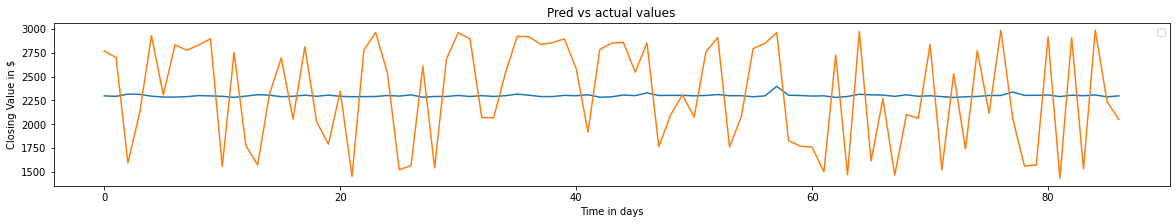

The r2 score of this prediction is :  0.000745018882407189
[*********************100%***********************]  1 of 1 completed
              volume_adi     volume_fi    volume_vpt
Date                                                
2020-07-17  1.144611e+09  3.975445e+07 -1.546890e+06
2020-07-20  1.224369e+09  6.026745e+07  1.717115e+06
2020-07-21  1.142179e+09  3.159919e+07  4.758037e+05
2020-07-22  1.140071e+09  3.054971e+07 -1.177522e+06
2020-07-23  1.007990e+09 -9.841976e+07 -8.716910e+06
...                  ...           ...           ...
2022-03-30  3.084397e+09  1.156013e+08  1.308749e+06
2022-03-31  2.993271e+09  5.256737e+07 -2.447752e+06
2022-04-01  3.041454e+09  4.168486e+07 -1.967000e+06
2022-04-04  3.116034e+09  8.084629e+07  1.676583e+06
2022-04-05  3.066848e+09  3.385419e+07  4.214255e+05

[434 rows x 3 columns]
Date
2020-07-17     96.327499
2020-07-20     98.357498
2020-07-21     97.000000
2020-07-22     97.272499
2020-07-23     92.845001
                 ...    
2022

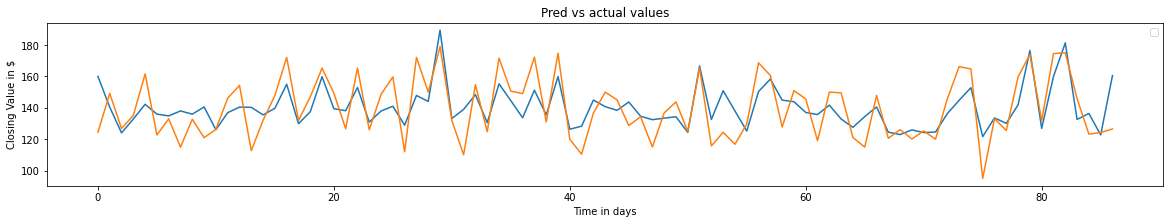

The r2 score of this prediction is :  0.5021599478718215
[*********************100%***********************]  1 of 1 completed
              volume_adi      volume_fi     volume_vpt   volume_nvi  \
Date                                                                  
2020-07-17 -9.805649e+05   -5298.048881    -375.399979  1065.902252   
2020-07-20 -1.059755e+06   -7022.764018    2612.083190  1065.902252   
2020-07-21 -1.101912e+06   -6148.229247   -1369.949247  1065.094732   
2020-07-22 -1.163248e+06   -8620.187158   -1846.267886  1065.094732   
2020-07-23 -1.186726e+06  -17995.878385   -7520.469999  1065.094732   
...                  ...            ...            ...          ...   
2022-03-30 -9.018700e+06   14879.602012   18257.261832   802.972432   
2022-03-31 -8.793054e+06   17113.809116   16625.241492   802.972432   
2022-04-01 -8.725868e+06 -205523.261568 -173621.569197   802.972432   
2022-04-04 -8.693822e+06 -195390.810037 -196096.708874   771.350429   
2022-04-05 -8.629055e+

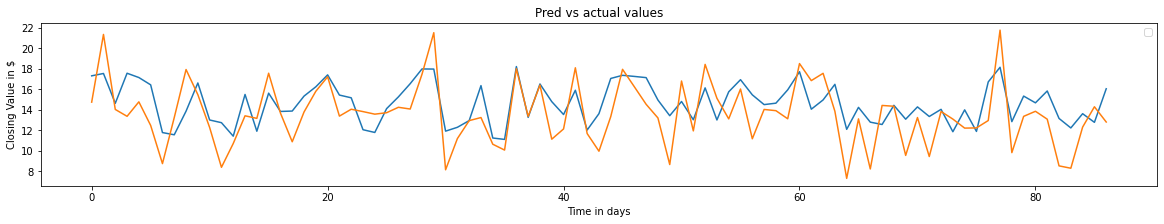

The r2 score of this prediction is :  0.3402231054902176
[*********************100%***********************]  1 of 1 completed
             Volume
Date               
2020-07-17  1756100
2020-07-20  2906700
2020-07-21  2403700
2020-07-22  1212300
2020-07-23  2950800
...             ...
2022-03-30  1487700
2022-03-31  1948800
2022-04-01  1868300
2022-04-04  1932700
2022-04-05  1788000

[434 rows x 1 columns]
Date
2020-07-17    73.000000
2020-07-20    76.940002
2020-07-21    76.580002
2020-07-22    76.000000
2020-07-23    74.629997
                ...    
2022-03-30    36.040001
2022-03-31    36.279999
2022-04-01    36.520000
2022-04-04    37.029999
2022-04-05    36.209999
Name: Close, Length: 434, dtype: float64
Epoch 1/10
11/11 [==============================] - 18s 12ms/step - loss: 0.3145 - mae: 0.4921
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.2823 - mae: 0.4610
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.2454 - mae: 0.43

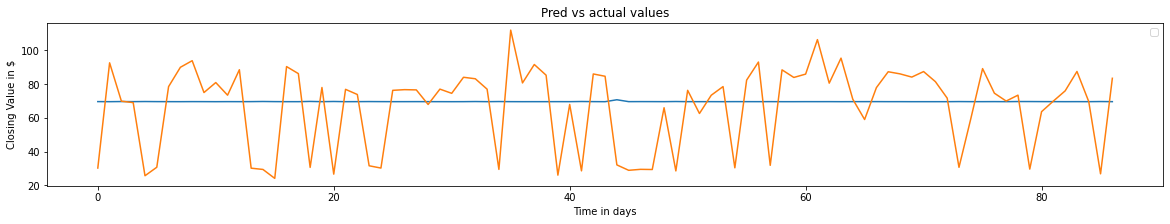

The r2 score of this prediction is :  -0.020161416266538


<Figure size 1440x216 with 0 Axes>

In [50]:
for i in stocks:
    final_pca_func(i)

[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 18s 141ms/step - loss: 0.1976 - mae: 0.3654
Epoch 2/10
11/11 [==============================] - 2s 153ms/step - loss: 0.0350 - mae: 0.1581
Epoch 3/10
11/11 [==============================] - 2s 142ms/step - loss: 0.0162 - mae: 0.1059
Epoch 4/10
11/11 [==============================] - 2s 143ms/step - loss: 0.0069 - mae: 0.0646
Epoch 5/10
11/11 [==============================] - 2s 151ms/step - loss: 0.0034 - mae: 0.0457
Epoch 6/10
11/11 [==============================] - 2s 140ms/step - loss: 0.0034 - mae: 0.0465
Epoch 7/10
11/11 [==============================] - 2s 148ms/step - loss: 0.0028 - mae: 0.0407
Epoch 8/10
11/11 [==============================] - 2s 141ms/step - loss: 0.0023 - mae: 0.0372
Epoch 9/10
11/11 [==============================] - 2s 140ms/step - loss: 0.0019 - mae: 0.0330
Epoch 10/10
11/11 [==============================] - 2s 151ms/step - loss: 

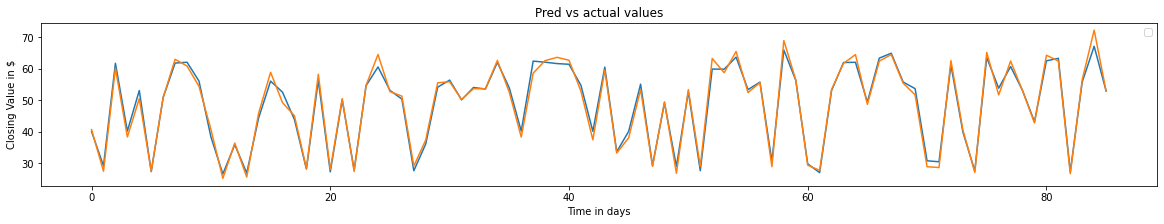

The r2 score of this prediction is :  0.9851884731394334
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 19s 100ms/step - loss: 0.1541 - mae: 0.3277
Epoch 2/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0261 - mae: 0.1286
Epoch 3/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0144 - mae: 0.1020
Epoch 4/10
11/11 [==============================] - 1s 134ms/step - loss: 0.0081 - mae: 0.0730
Epoch 5/10
11/11 [==============================] - 2s 143ms/step - loss: 0.0058 - mae: 0.0607
Epoch 6/10
11/11 [==============================] - 2s 146ms/step - loss: 0.0050 - mae: 0.0571
Epoch 7/10
11/11 [==============================] - 2s 138ms/step - loss: 0.0051 - mae: 0.0563
Epoch 8/10
11/11 [==============================] - 1s 100ms/step - loss: 0.0049 - mae: 0.0566
Epoch 9/10
11/11 [==============================] - 2s 166ms/step - loss: 0.0048 - mae: 0.0548
Epoch 10/10
11/11 

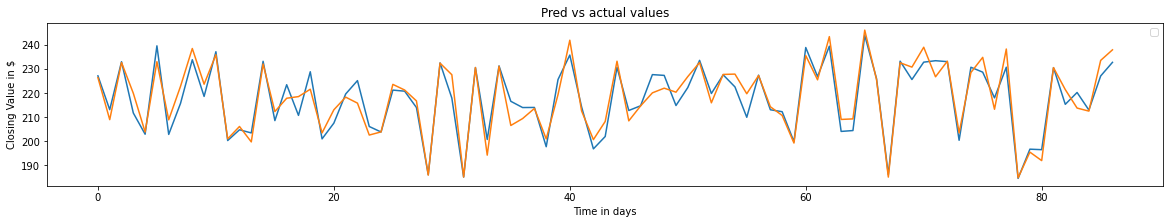

The r2 score of this prediction is :  0.9001389886956802
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 17s 126ms/step - loss: 0.1853 - mae: 0.3394
Epoch 2/10
11/11 [==============================] - 1s 127ms/step - loss: 0.0283 - mae: 0.1483
Epoch 3/10
11/11 [==============================] - 1s 136ms/step - loss: 0.0119 - mae: 0.0909
Epoch 4/10
11/11 [==============================] - 1s 131ms/step - loss: 0.0054 - mae: 0.0589
Epoch 5/10
11/11 [==============================] - 1s 135ms/step - loss: 0.0034 - mae: 0.0477
Epoch 6/10
11/11 [==============================] - 1s 129ms/step - loss: 0.0026 - mae: 0.0410
Epoch 7/10
11/11 [==============================] - 1s 127ms/step - loss: 0.0022 - mae: 0.0379
Epoch 8/10
11/11 [==============================] - 2s 138ms/step - loss: 0.0023 - mae: 0.0386
Epoch 9/10
11/11 [==============================] - 1s 121ms/step - loss: 0.0020 - mae: 0.0356
Epoch 10/10
11/11 

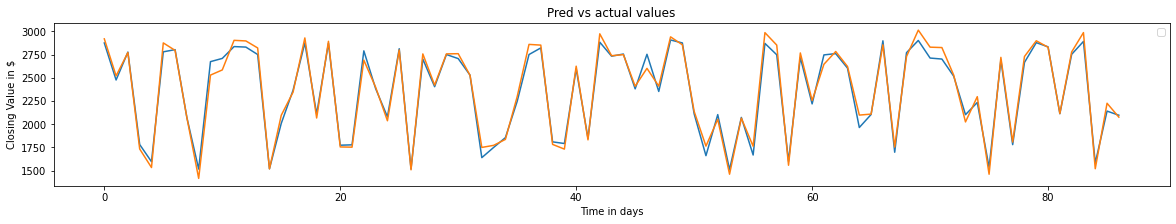

The r2 score of this prediction is :  0.9824034794895702
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 20s 122ms/step - loss: 0.1670 - mae: 0.3408
Epoch 2/10
11/11 [==============================] - 1s 110ms/step - loss: 0.0270 - mae: 0.1315
Epoch 3/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0120 - mae: 0.0882
Epoch 4/10
11/11 [==============================] - 1s 112ms/step - loss: 0.0073 - mae: 0.0653
Epoch 5/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0041 - mae: 0.0501
Epoch 6/10
11/11 [==============================] - 2s 141ms/step - loss: 0.0039 - mae: 0.0491 0s - loss: 0.0038 - mae: 0.
Epoch 7/10
11/11 [==============================] - 2s 163ms/step - loss: 0.0033 - mae: 0.0461
Epoch 8/10
11/11 [==============================] - 1s 101ms/step - loss: 0.0032 - mae: 0.0458
Epoch 9/10
11/11 [==============================] - 1s 103ms/step - loss: 0.0038 - ma

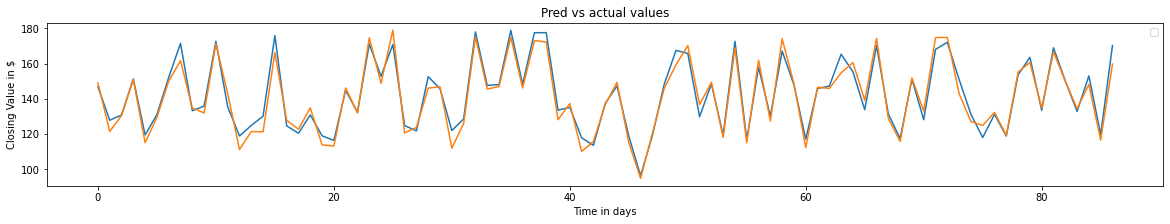

The r2 score of this prediction is :  0.9482971549909771
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 14s 121ms/step - loss: 0.1216 - mae: 0.2931
Epoch 2/10
11/11 [==============================] - 1s 122ms/step - loss: 0.0239 - mae: 0.1234
Epoch 3/10
11/11 [==============================] - 1s 129ms/step - loss: 0.0126 - mae: 0.0922
Epoch 4/10
11/11 [==============================] - 1s 115ms/step - loss: 0.0108 - mae: 0.0822
Epoch 5/10
11/11 [==============================] - 1s 99ms/step - loss: 0.0069 - mae: 0.0664
Epoch 6/10
11/11 [==============================] - 1s 127ms/step - loss: 0.0052 - mae: 0.0568
Epoch 7/10
11/11 [==============================] - 1s 124ms/step - loss: 0.0055 - mae: 0.0571
Epoch 8/10
11/11 [==============================] - 1s 126ms/step - loss: 0.0055 - mae: 0.0585
Epoch 9/10
11/11 [==============================] - 1s 130ms/step - loss: 0.0050 - mae: 0.0550
Epoch 10/10
11/11 [

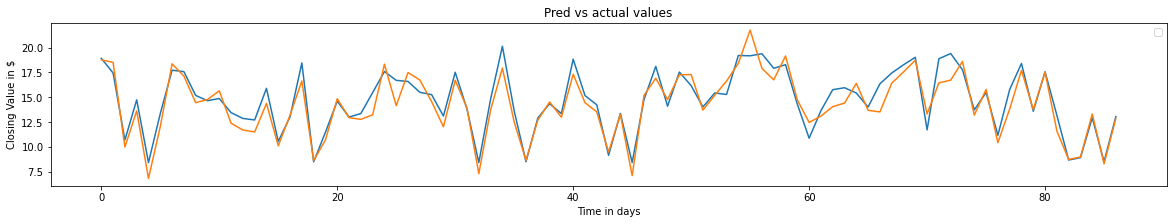

The r2 score of this prediction is :  0.8679700945585814
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 13s 89ms/step - loss: 0.1452 - mae: 0.3123
Epoch 2/10
11/11 [==============================] - 1s 85ms/step - loss: 0.0219 - mae: 0.1309
Epoch 3/10
11/11 [==============================] - 1s 86ms/step - loss: 0.0102 - mae: 0.0834
Epoch 4/10
11/11 [==============================] - 1s 88ms/step - loss: 0.0047 - mae: 0.0569
Epoch 5/10
11/11 [==============================] - 1s 87ms/step - loss: 0.0034 - mae: 0.0457
Epoch 6/10
11/11 [==============================] - 1s 88ms/step - loss: 0.0029 - mae: 0.0424
Epoch 7/10
11/11 [==============================] - 1s 89ms/step - loss: 0.0029 - mae: 0.0423
Epoch 8/10
11/11 [==============================] - 1s 93ms/step - loss: 0.0030 - mae: 0.0435
Epoch 9/10
11/11 [==============================] - 1s 122ms/step - loss: 0.0028 - mae: 0.0418
Epoch 10/10
11/11 [=======

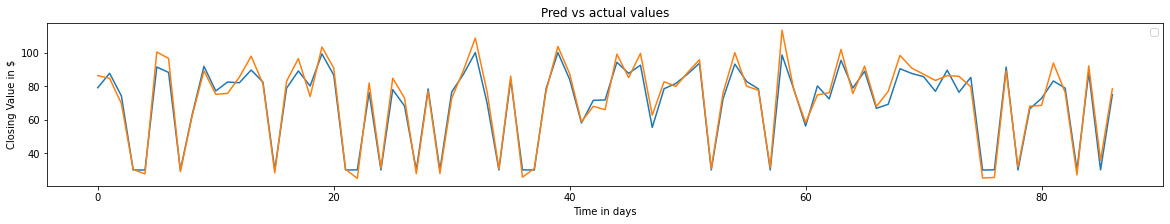

The r2 score of this prediction is :  0.962455913467628


<Figure size 1440x216 with 0 Axes>

In [51]:
for i in stocks:
    final_kbest_func(i)